# IPython マジックコマンド

IPython の **magic command（マジックコマンド）** は、
Jupyter Notebook や IPython シェルで便利な“拡張コマンド”を実現する仕組みです。
`%time`, `%lsmagic`, `%matplotlib` などが代表例です。

IPython で使える、通常の Python 文とは異なる**特別なコマンド**です。

| 種類                     | 記法            | 説明            |
| ---------------------- | ------------- | ------------- |
| **Line magic（行マジック）**  | `%magicname`  | 1 行だけに適用される   |
| **Cell magic（セルマジック）** | `%%magicname` | セル全体の内容に適用される |

In [39]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %code_wrap  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %mamba  %matplotlib  %micromamba  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %uv  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cffi  %%cmd  %%code_wrap  %%debug  %%file  %%html  %%javascript  %

In [47]:
from IPython.core.magic import register_line_magic


@register_line_magic
def hello(line):
    for i in range(5):
        print("Hello,", line)

In [48]:
%hello everyone

Hello, everyone
Hello, everyone
Hello, everyone
Hello, everyone
Hello, everyone


In [50]:
from IPython.core.magic import register_cell_magic


@register_cell_magic
def demo(line, cell):
    print("line arguments  :", line)
    print("cell content:\n", cell)

In [51]:
%%demo arg1 arg2
x = 10
x + 20

line arguments  : arg1 arg2
cell content:
 x = 10
x + 20



## C言語関数

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
%load_ext gccffi

In [4]:
%%cffi -i
int add(int x, int y){
    return x + y;
}

In [5]:
add(1, 2)

3

16 進定数 **0x5F3759DF** と呼ばれることもあるこの手法は、IEEE 754 形式の 32 ビット浮動小数点数( x ) の平方根の逆数（乗法逆数）、すなわち
(\frac{1}{\sqrt{x}}) を近似的に求めるアルゴリズムである。

$$ f(x) = \frac{1}{\sqrt{x}} $$

このアルゴリズムは、1999 年に発売された 3D グラフィックスを多用する FPS ゲーム **Quake III Arena** に実装されたことで最もよく知られている。

In [10]:
%%cffi -i
float Q_rsqrt0( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;

	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // evil floating point bit level hacking
	i  = 0x5f3759df - ( i >> 1 );               // what the fuck?
	y  = * ( float * ) &i;
//	y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
//	y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed

	return y;
}

float Q_rsqrt1( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;

	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // evil floating point bit level hacking
	i  = 0x5f3759df - ( i >> 1 );               // what the fuck?
	y  = * ( float * ) &i;
	y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
//	y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed

	return y;
}

float Q_rsqrt2( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;

	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // evil floating point bit level hacking
	i  = 0x5f3759df - ( i >> 1 );               // what the fuck?
	y  = * ( float * ) &i;
	y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
    y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed

	return y;
}

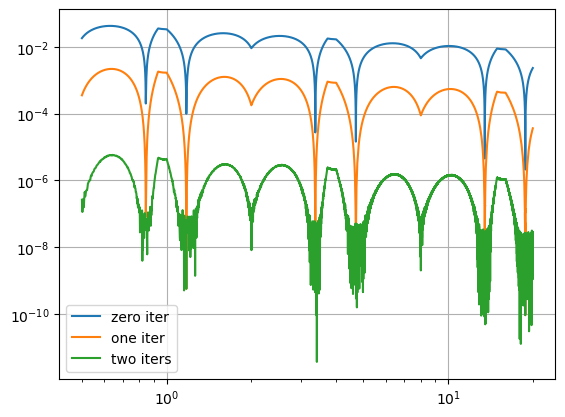

In [14]:
x = np.linspace(0.5, 20, 10000)
y0 = np.vectorize(Q_rsqrt0)(x)
y1 = np.vectorize(Q_rsqrt1)(x)
y2 = np.vectorize(Q_rsqrt2)(x)
y_real = 1 / np.sqrt(x)

plt.semilogy(x, np.abs(y0 - y_real), label="zero iter")
plt.semilogy(x, np.abs(y1 - y_real), label="one iter")
plt.semilogx(x, np.abs(y2 - y_real), label="two iters")
plt.legend()
plt.grid(True);

## 数式計算

In [1]:
from IPython.core.magic import register_cell_magic
from IPython.display import display
import sympy as sp
import ast
import keyword
import builtins


def _find_loaded_names(tree: ast.AST):
    """Return set of identifier names that are used (Load context) in AST."""
    names = set()
    for node in ast.walk(tree):
        if isinstance(node, ast.Name) and isinstance(node.ctx, ast.Load):
            names.add(node.id)
    return names


@register_cell_magic
def sympy(line, cell):
    """
    Execute cell in SymPy mode:
    - Auto declare unknown names as sympy.symbols
    - Display EVERY expression result (except None)
    - Do NOT display assignments or statements
    """
    # Prepare SymPy namespace
    ns = {k: getattr(sp, k) for k in dir(sp) if not k.startswith("_")}
    ns.update({"sp": sp})

    # Parse cell
    try:
        tree = ast.parse(cell, mode="exec")
    except SyntaxError:
        raise

    body = tree.body

    # --- Auto-declare symbols ---
    names = _find_loaded_names(tree)
    builtin_names = set(dir(builtins))
    sympy_names = set(ns.keys())
    excluded = set(keyword.kwlist) | builtin_names | {"display"}

    syms_to_create = {n for n in names if n not in sympy_names and n not in excluded}

    if syms_to_create:
        created = sp.symbols(" ".join(sorted(syms_to_create)))
        if isinstance(created, tuple):
            for name, sym in zip(sorted(syms_to_create), created):
                ns[name] = sym
        else:
            ns[next(iter(syms_to_create))] = created

    # --- Execute line by line ---
    for stmt in body:
        if isinstance(stmt, ast.Expr):
            # This is an expression → eval & display result
            expr_ast = ast.Expression(stmt.value)
            ast.fix_missing_locations(expr_ast)
            value = eval(compile(expr_ast, "<sympy expr>", "eval"), ns)
            ns["_"] = value
            if value is not None:
                display(value)
        else:
            # This is assignment / import / statement → exec without output
            one = ast.Module(body=[stmt], type_ignores=[])
            ast.fix_missing_locations(one)
            exec(compile(one, "<sympy stmt>", "exec"), ns)

    return None

In [2]:
%%sympy
a + b
c = a*b
(c + a)**2

a + b

(a*b + a)**2

In [3]:
%%sympy
expand_trig(sin(x + y))
factor(x**2 + 2*x + 1)
expand((x + y)**3)

sin(x)*cos(y) + sin(y)*cos(x)

(x + 1)**2

x**3 + 3*x**2*y + 3*x*y**2 + y**3

In [4]:
%%sympy
expr = Integral( 1 / (x**2 - 1), x)
Eq(expr, expr.doit())

expr = Integral( 1 / (sin(x) + cos(x) + 1), x)
Eq(expr, expr.doit())

Eq(Integral(1/(x**2 - 1), x), log(x - 1)/2 - log(x + 1)/2)

Eq(Integral(1/(sin(x) + cos(x) + 1), x), log(tan(x/2) + 1))